* notebook created by nov05 on 2024-12-01  
* The training job part can be run in local conda env `awsmle_py310`.   
* The report generation part needs to be run in `SageMaker Studio`, as it doesn't work properly on a local computer.

---  

* AWS official documentation ["debugging and improving model performance"](https://docs.aws.amazon.com/sagemaker/latest/dg/train-debug-and-improve-model-performance.html)   
* [List of built-in rules](https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-built-in-rules.html)  
<br>  
* notebooks ["Amazon SageMaker Debugger Examples"](https://github.com/aws/amazon-sagemaker-examples/tree/main/sagemaker-debugger/)
* GibHub ["pytorch_script_change_smdebug.ipynb"](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_model_debugging/pytorch_script_change_smdebug.ipynb)  
* GitHub ["pt-resnet-profiling-single-gpu-single-node.ipynb"](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-debugger/pytorch_profiling/pt-resnet-profiling-single-gpu-single-node.ipynb)  

---  

## Set up AWS credentials and roles  

In [19]:
## windows cmd to launch notepad to edit aws credential file
!notepad C:\Users\guido\.aws\credentials

In [48]:
## reset the session after updating credentials
import boto3 # type: ignore
boto3.DEFAULT_SESSION = None
import sagemaker # type: ignore
from sagemaker import get_execution_role # type: ignore

role_arn = get_execution_role()  ## get role ARN
if 'AmazonSageMaker-ExecutionRole' not in role_arn:
    ## Go to "IAM - Roles", search for "SageMaker", find the execution role.
    voclabs_role_arn = role_arn  ## If local, Role ARN: arn:aws:iam::807711953667:role/voclabs
    role_arn = "arn:aws:iam::852125600954:role/service-role/AmazonSageMaker-ExecutionRole-20241119T203081"
session = sagemaker.Session()
region = session.boto_region_name
bucket = session.default_bucket()
print("AWS Region: {}".format(region))
print("Default SageMaker Bucket: {}".format(bucket))
print("Role ARN (SageMaker execution): {}".format(role_arn))
print(f"Role ARN (voclabs): {voclabs_role_arn}")

import wandb
## generate secrets.env. remember to add it to .gitignore  
wandb.sagemaker_auth(path="scripts")  

[12/07/24 19:59:55] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=150854;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=680104;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

[12/07/24 19:59:57] WARNING  Couldn't call 'get_role' to get Role ARN from role name voclabs to get ]8;id=905136;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=248589;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#5902\5902]8;;\
                             Role path.                                                                            

                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=819524;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=719574;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

AWS Region: us-east-1
Default SageMaker Bucket: sagemaker-us-east-1-852125600954
Role ARN (SageMaker execution): arn:aws:iam::852125600954:role/service-role/AmazonSageMaker-ExecutionRole-20241119T203081
Role ARN (voclabs): arn:aws:iam::852125600954:role/voclabs


---   

## **Create a training job with debugging and profiling enabled**  

In [2]:
from sagemaker.pytorch import PyTorch
from sagemaker.inputs import TrainingInput
from datetime import datetime
data_base_path = "s3://p3-dog-breed-image-classification/dogImages/"
train_data = TrainingInput(data_base_path+"train/", content_type="image/jpeg")
val_data = TrainingInput(data_base_path+"valid/", content_type="image/jpeg")
test_data = TrainingInput(data_base_path+"test/", content_type="image/jpeg")
## ⚠️ don't use prefix in output_path, cause source folder will be created 
## at bucket level, while other folders, e.g. debug-output, at prefix levle.
output_path = "s3://p3-dog-breed-image-classification/"  

In [3]:
from sagemaker.debugger import (
    Rule,
    ## debugger
    DebuggerHookConfig,
    rule_configs,
    ## profiler 
    ProfilerRule,
    ProfilerConfig,
    FrameworkProfile
)
hyperparameters = {
    'epochs': 40,   
    'batch-size': 32,   
    'opt-learning-rate': 8e-5,  
    'opt-weight-decay': 1e-5,  
    'lr-sched-step-size': 5,  
    'lr-sched-gamma': 0.5,
    'early-stopping-patience': 5,
    'model-type': 'resnet50', 
    'wandb': True,  
    'debug': True, 
}
rules = [
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "100", 
        "eval.save_interval": "10"
    }
)
profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params=FrameworkProfile(num_steps=10)
)
# TODO: Create and fit an estimator
estimator = PyTorch(
    entry_point='train.py',  # Your training script that defines the ResNet50 model and training loop
    source_dir='scripts',  # Directory where your script and dependencies are stored
    role=role_arn,
    framework_version='1.13.1',  # Use the PyTorch version you need
    py_version='py39',
    instance_count=1,  # Adjust based on the number of instances you want to use
    # instance_type='ml.p3.2xlarge',  # 16GB, Use GPU instances for deep learning
    instance_type='ml.g4dn.xlarge',  ## 16GB
    output_path=output_path,  ## if not specify, output to the sagemaker default bucket
    hyperparameters=hyperparameters,
    # use_spot_instances=True,
    ## Debugger and profiler parameters
    rules=rules,
    debugger_hook_config=hook_config,    
    profiler_config=profiler_config,
)

[12/07/24 12:52:19] WARNING  Framework profiling will be deprecated from tensorflow 2.12 and     ]8;id=724865;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\deprecations.py\deprecations.py]8;;\:]8;id=543606;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\deprecations.py#34\34]8;;\
                             pytorch 2.0 in sagemaker>=2.                                                          
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=824726;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=9814;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

                    INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=279289;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=498556;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

In [5]:
%%time
estimator.fit(
    wait=True,  
    job_name=f"p3-dog-breeds-job-{datetime.now().strftime('%Y%m%d-%H%M%S')}",  
    inputs={
        "train": train_data,  
        "validation": val_data, 
        "test": test_data,
    },  
)

[12/07/24 13:06:16] INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=571541;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py\image_uris.py]8;;\:]8;id=347197;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\image_uris.py#674\674]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name: p3-dog-breeds-job-20241207-130615     ]8;id=16679;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py\session.py]8;;\:]8;id=327390;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\sagemaker\session.py#1042\1042]8;;\

2024-12-07 19:06:19 Starting - Starting the training job...
2024-12-07 19:06:50 Starting - Preparing the instances for trainingPoorWeightInitialization: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-12-07 19:07:24 Downloading - Downloading input data......
2024-12-07 19:08:30 Downloading - Downloading the training image...............
2024-12-07 19:11:12 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/opt/conda/lib/python3.9/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.9/site-packages/paramiko/transport.py:259: 

In [54]:
## get debug_output_path from training job name
training_job_name = estimator.latest_training_job.name
# training_job_name = 'p3-dog-breeds-job-20241207-130615'  ## ⚠️ manually specify the training job name
sagemaker_client = boto3.client('sagemaker')
training_job_details = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
## Check if Debugger is enabled and get the path to the Debugger artifacts
if 'DebugHookConfig' in training_job_details and 'S3OutputPath' in training_job_details['DebugHookConfig']:
    debug_output_path = training_job_details['DebugHookConfig']['S3OutputPath'] + training_job_name + "/debug-output/"
    print(f"👉 Debug output path: {debug_output_path}")
else:
    print("⚠️ Debugger is not enabled for this training job.")

👉 Debug output path: s3://p3-dog-breed-image-classification/p3-dog-breeds-job-20241207-130615/debug-output/


In [65]:
## get the autogenerated folder name of profiler report
import os
training_job_name = 'p3-dog-breeds-job-20241207-130615'  ## ⚠️ manually specify the training job name
sagemaker_client = boto3.client('sagemaker')
training_job_description = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
profiler_report_folder = [
    rule["RuleConfigurationName"]
    for rule in training_job_description['ProfilerRuleConfigurations']
    if "Profiler" in rule["RuleConfigurationName"]
][0]
filename = (
    training_job_details['DebugHookConfig']['S3OutputPath'] +
    training_job_name + "/rule-output/" + profiler_report_folder + 
    "/profiler-output/profiler-report.html"
)
print("👉 Profiler report:", filename)

👉 Profiler report: s3://p3-dog-breed-image-classification/p3-dog-breeds-job-20241207-130615/rule-output/ProfilerReport/profiler-output/profiler-report.html


In [ ]:
## download the file from AWS S3 to local
!aws s3 cp {filename} misc/profiler-report.html

Completed 256.0 KiB/386.2 KiB (419.5 KiB/s) with 1 file(s) remaining
Completed 386.2 KiB/386.2 KiB (615.1 KiB/s) with 1 file(s) remaining
download: s3://p3-dog-breed-image-classification/p3-dog-breeds-job-20241207-130615/rule-output/ProfilerReport/profiler-output/profiler-report.html to misc\profiler-report.html


---   

# **⚠️ The following part needs to be run in SageMaker Studio**  

* Cause locally I am using Windows OS, which isn't compatible with the code.   
  I could set up a local env in WSL2, but I don't have time to do it now for this project.  

In [ ]:
!pip install smdebug
## Successfully installed protobuf-3.20.3 pyinstrument-3.4.2 pyinstrument-cext-0.2.4 smdebug-1.0.34

In [ ]:
import boto3 # type: ignore
import sagemaker # type: ignore
from sagemaker import get_execution_role # type: ignore
role_arn = get_execution_role()  ## get role ARN
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket =sagemaker_session.default_bucket()
print("AWS Region: {}".format(region))
print("Default SageMaker Bucket: {}".format(bucket))
print("Role ARN: {}".format(role_arn))

In [23]:
## get debug_output_path from training job name
training_job_name = 'p3-dog-breeds-job-20241207-130615'  ## ⚠️ manually specify the training job name
sagemaker_client = boto3.client('sagemaker')
training_job_details = sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
## Check if Debugger is enabled and get the path to the Debugger artifacts
if 'DebugHookConfig' in training_job_details and 'S3OutputPath' in training_job_details['DebugHookConfig']:
    debug_output_path = training_job_details['DebugHookConfig']['S3OutputPath'] + training_job_name + "/debug-output/"
    print(f"👉 Debug output path: {debug_output_path}")
else:
    print("⚠️ Debugger is not enabled for this training job.")

[12/07/24 18:45:28] INFO     Found credentials in shared credentials file: ~/.aws/credentials   ]8;id=539542;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py\credentials.py]8;;\:]8;id=265424;file://d:\Users\guido\miniconda3\envs\awsmle_py310\lib\site-packages\botocore\credentials.py#1278\1278]8;;\

👉 Debug output path: s3://p3-dog-breed-image-classification/p3-dog-breeds-job-20241207-130615/debug-output/


## **Create debug trial**    

* ⚠️ It is probably windows path delimiter that causes the issue.  
```text  
[2024-12-07 14:10:09.744 guido:3436 INFO s3_trial.py:42] Loading trial  at path s3://p3-dog-breed-image-classification/p3-dog-breeds-job-20241207-130615/debug-output/
[2024-12-07 14:10:12.563 guido:3436 WARNING s3handler.py:147] Unable to list files for p3-dog-breed-image-classification\p3-dog-breeds-job-20241207-130615 with prefix debug-output/training_job_end.ts
```

In [ ]:
%%time
## create trial from debug output
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
trial = create_trial(debug_output_path)  ## S3 path
## fetch tensor name and their lengths
trial.tensor_names()

In [ ]:
## check the length of the last tensor
len(trial.tensor(trial.tensor_names()[-1]).steps(mode=ModeKeys.TRAIN))

38

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


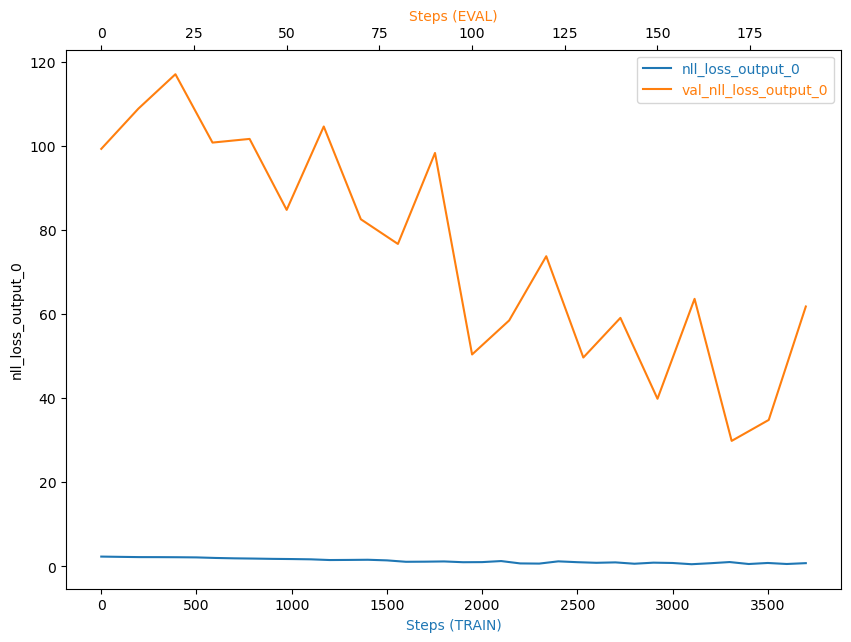

In [ ]:
## set up function to plot the output tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals


def plot_tensor(trial, tensor_name):
    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("TRAIN data loaded")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("EVAL data loaded")

    plt.figure(figsize=(10, 7))
    host = host_subplot(111)
    par = host.twiny()
    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("TRAIN plot completed")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("EVAL plot completed")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())
    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())
    plt.ylabel(tensor_name)
    plt.show()


plot_tensor(trial, "nll_loss_output_0")

## **👉 Profiling**

In [43]:
import boto3
session = boto3.session.Session()
region = session.region_name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: p3-dog-breeds-job-20241207-130615
Region: us-east-1


In [ ]:
## get the autogenerated folder name of profiler report
profiler_report_folder = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
training_job = TrainingJob(training_job_name, region)
training_job.wait_for_sys_profiling_data_to_be_available()

In [ ]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts
system_metrics_reader = training_job.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()
view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)